<a href="https://colab.research.google.com/github/jameschapman19/cca_zoo/blob/main/tutorial_notebooks/cca_zoo_sparsity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A tutorial on using cca-zoo to generate multiview models with sparsity on weights

In [ ]:
!pip install cca-zoo

You should consider upgrading via the 'c:\users\chapm\pycharmprojects\cca_zoo\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
from cca_zoo.models import PMD, SCCA, ElasticCCA, CCA, PLS, SCCA_ADMM, SpanCCA
from cca_zoo.model_selection import GridSearchCV
from cca_zoo.data import generate_covariance_data
import matplotlib.pyplot as plt
import numpy as np
import itertools

## Generate some data
set the true correlation and the sparsity of the true weights

In [ ]:
np.random.seed(42)
n=200
p=100
q=100
view_1_sparsity=0.1
view_2_sparsity=0.1
true_latent_dims=1

(X,Y),(tx, ty)=generate_covariance_data(n,view_features=[p,q],latent_dims=true_latent_dims,
                                        view_sparsity=[view_1_sparsity,view_2_sparsity],correlation=[0.9])
#normalize weights for comparability
tx/=np.sqrt(n)
ty/=np.sqrt(n)

In [ ]:
def plot_true_weights_coloured(ax, weights, true_weights, title=''):
    ind = np.arange(len(true_weights))
    mask = np.squeeze(true_weights == 0)
    ax.scatter(ind[~mask], weights[~mask], c='b')
    ax.scatter(ind[mask], weights[mask], c='r')
    ax.set_title(title)

def plot_model_weights(wx,wy,tx,ty):
    fig,axs=plt.subplots(2,2,sharex=True,sharey=True)
    plot_true_weights_coloured(axs[0,0],tx,tx,title='true x weights')
    plot_true_weights_coloured(axs[0,1],ty,ty,title='true y weights')
    plot_true_weights_coloured(axs[1,0],wx,tx,title='model x weights')
    plot_true_weights_coloured(axs[1,1],wy,ty,title='model y weights')
    plt.tight_layout()
    plt.show()

## First try with CCA

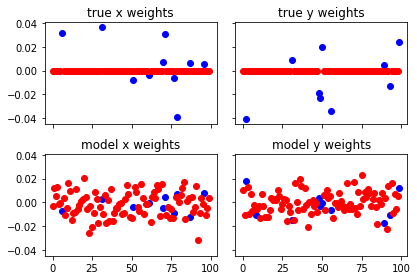

In [ ]:
#fit a cca model
cca=CCA().fit((X,Y))

plot_model_weights(cca.weights[0],cca.weights[1],tx,ty)

## PLS

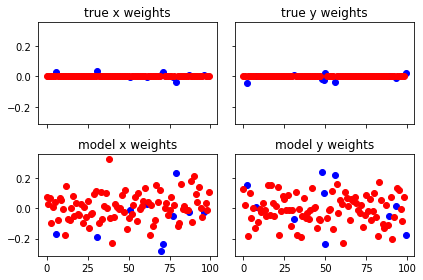

In [ ]:
#fit a pls model
pls=PLS().fit((X,Y))

plot_model_weights(pls.weights[0],pls.weights[1],tx,ty)

## Penalized Matrix Decomposition (Sparse CCA by Witten)
Initially set c=2 for both views arbitrarily

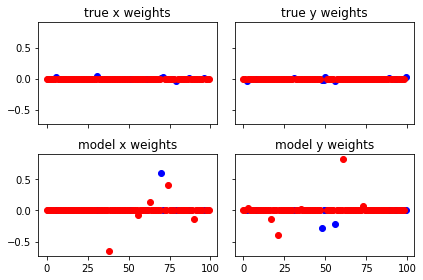

In [ ]:
#fit a pmd model
pmd=PMD(c=[2,2]).fit((X,Y))

plot_model_weights(pmd.weights[0],pmd.weights[1],tx,ty)

## Tracking the objective
For these iterative algorithms, you can access the convergence over iterations

Text(0.5, 0, '#iterations')

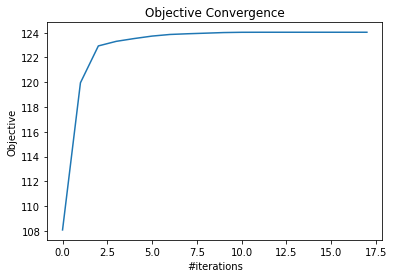

In [ ]:
#Convergence
plt.figure()
plt.title('Objective Convergence')
plt.plot(np.array(pmd.objective).T)
plt.ylabel('Objective')
plt.xlabel('#iterations')

### We can also tune the hyperparameter using GridSearchCV

cross validation
number of folds:  3
Best score :  0.22767922740055888
Standard deviation :  0.327578876174103
{'c': (3, 3)}


PMD(c=(3, 3))

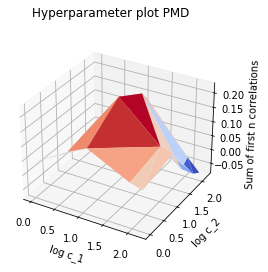

In [ ]:
#Set up a grid. We can't use c<1 or c>sqrt(#features)
c1 = [1, 3, 7, 9]
c2 = [1, 3, 7, 9]
param_grid = {'c': [c1,c2]}

#GridSearchCV can use multiple cores (jobs) and takes folds (number of cv folds) as a parameter. It can also produce a plot.
pmd = GridSearchCV(PMD(),param_grid=param_grid,
    cv=3,
    verbose=True)

Also the model object now has a pandas dataframe containing the results from each fold

In [ ]:
pmd.cv_results_

,fold_0,fold_1,fold_2,c
0,-0.115996,0.219103,0.025030,"(1, 1)"
1,-0.081632,0.101298,-0.068190,"(1, 3)"
2,-0.127065,0.195795,-0.042409,"(1, 7)"
3,-0.132943,0.192117,-0.009374,"(1, 9)"
4,0.146737,0.269503,0.015319,"(3, 1)"
5,0.657348,0.162847,-0.137157,"(3, 3)"
6,0.460360,0.239803,-0.178891,"(3, 7)"
7,0.415766,0.161078,-0.184871,"(3, 9)"
8,0.161620,0.048646,0.005979,"(7, 1)"
9,0.117946,0.072350,0.102092,"(7, 3)"


## Sparse CCA by iterative lasso (Mai)

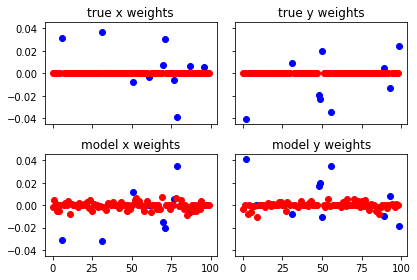

Text(0.5, 0, '#iterations')

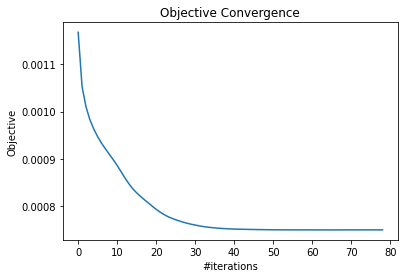

In [ ]:
#fit a scca model
scca=SCCA(c=[1e-3,1e-3]).fit((X,Y))

plot_model_weights(scca.weights[0],scca.weights[1],tx,ty)

#Convergence
plt.figure()
plt.title('Objective Convergence')
plt.plot(np.array(scca.objective).T)
plt.ylabel('Objective')
plt.xlabel('#iterations')

### Positivity Constraints
In this case it isn't helpful (the data were generated with positive and negative weights) but is a cool functionality!

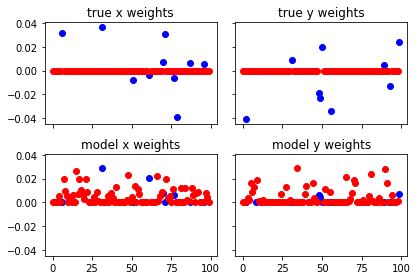

Text(0.5, 0, '#iterations')

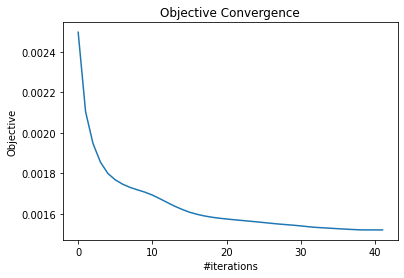

In [ ]:
#fit a scca model with positivity constraints
scca_pos=SCCA(c=[1e-3,1e-3],positive=[True,True]).fit((X,Y))

plot_model_weights(scca_pos.weights[0],scca_pos.weights[1],tx,ty)

#Convergence
plt.figure()
plt.title('Objective Convergence')
plt.plot(np.array(scca_pos.objective).T)
plt.ylabel('Objective')
plt.xlabel('#iterations')

## Sparse CCA by iterative elastic net (adapted from Waaijenborg)

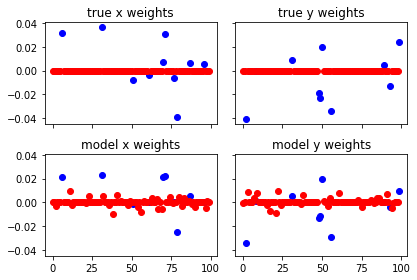

Text(0.5, 0, '#iterations')

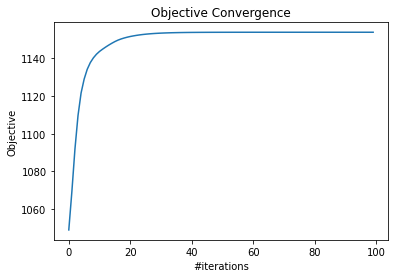

In [ ]:
#fit an elastic model
#for some reason this model needs REALLY big l2 regularisation. This is actually
#the same level of l1 regularisation as SCCA
elasticcca=ElasticCCA(c=[10000,10000],l1_ratio=[0.000001,0.000001]).fit((X,Y))

plot_model_weights(elasticcca.weights[0],elasticcca.weights[1],tx,ty)

#Convergence
plt.figure()
plt.title('Objective Convergence')
plt.plot(np.array(elasticcca.objective).T)
plt.ylabel('Objective')
plt.xlabel('#iterations')

## Sparse CCA by ADMM

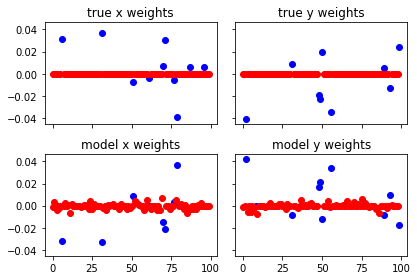

Text(0.5, 0, '#iterations')

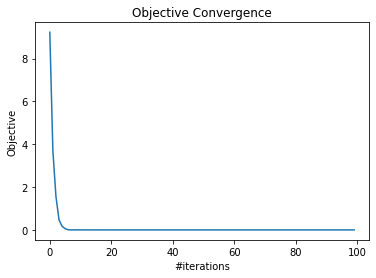

In [ ]:
#fit a scca_admm model
scca_admm=SCCA_ADMM(c=[1e-3,1e-3]).fit((X,Y))

plot_model_weights(scca_admm.weights[0],scca_admm.weights[1],tx,ty)

#Convergence
plt.figure()
plt.title('Objective Convergence')
plt.plot(np.array(scca_admm.objective).T)
plt.ylabel('Objective')
plt.xlabel('#iterations')

## Sparse CCA by random projection (Span CCA)
This time the regularisation parameter c is the l0 norm of the weights i.e. the maximum number of non-zero weights. Let's cheat and give it the correct numbers. We can also change the rank of the estimation as described in the paper

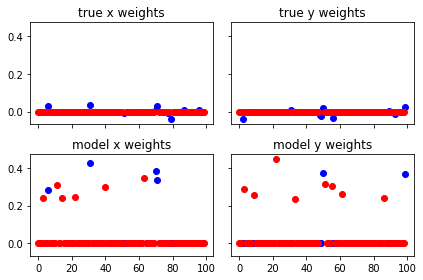

Text(0.5, 0, '#iterations')

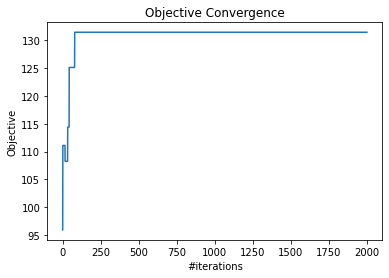

In [ ]:
#fit a spancca model
spancca=SpanCCA(c=[10,10],max_iter=2000,rank=20).fit((X,Y))

plot_model_weights(spancca.weights[0],spancca.weights[1],tx,ty)

#Convergence
plt.figure()
plt.title('Objective Convergence')
plt.plot(np.array(spancca.objective).T)
plt.ylabel('Objective')
plt.xlabel('#iterations')